In [1]:
""" Finding Trends of Stock Prices """
import pandas as pd 
import numpy as np 
import sqlite3 as sql 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append('/Users/jerald/Documents/Dir/Python/Stocks')
from bin.main import Manager, get_path 

connections = get_path('../../../')
J = Manager(connections)

Options db Connected: 2024-07-31 15:07:24.092905
Prices Connected: 2024-07-31 15:07:24.093818


In [2]:
prices = J.Pricedb.get_close(['amzn']).tail(130)
prices = prices.rename({list(prices.columns)[-1]: 'close'}, axis=1)
df = prices.pct_change().dropna()
dates = df.index
df.index = pd.to_datetime(df.index).to_period('B')
# df = df.sort_index().bfill().ffill()

In [3]:
import statsmodels.api as sm 
df_last_date = df.index[-1].strftime('%Y-%m-%d')
forecast_date = df.index[-1]
forecast_date = forecast_date.to_timestamp().strftime('%Y-%m-%d')

smax = sm.tsa.statespace.SARIMAX(df, trend = 'ct', order = (1,0,5)).fit(disp = False)
pred_dy = smax.get_prediction(dynamic = df_last_date)
pred_dy_ci = pred_dy.conf_int(alpha=0.10)

/Users/jerald/opt/miniconda3/envs/ds24/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [4]:
def training_forecast(prices, pred_dy, pred_dy_ci):
    """ 
    Return the predicted values and confidence intervals for the training data
        Prices: DataFrame of prices
        pred_dy: Predicted values
        pred_dy_ci: Confidence intervals
    """
    fitted_predictions = pred_dy.predicted_mean
    lowerpred, upperpred = pred_dy_ci.iloc[0]

    reconstructed = np.array([prices.iloc[0,0] * (1 + fitted_predictions.iloc[0])])
    reconstructed_lower = np.array([prices.iloc[0,0] * (1 + lowerpred)])
    reconstructed_upper = np.array([prices.iloc[0,0] * (1 + upperpred)])

    for i in range(1, len(fitted_predictions)):
        predicted_price = reconstructed[-1] * (1 + fitted_predictions.iloc[i])
        # To find the upper and lower bounds, use the predicted price ± (predicted price * predicted confidence interval)
        upper_predicted_price = reconstructed[-1] + (reconstructed[-1] * pred_dy_ci.iloc[i, 1])
        lower_predicted_price = reconstructed[-1] + (reconstructed[-1] * pred_dy_ci.iloc[i, 0])

        reconstructed = np.append(reconstructed, predicted_price)
        reconstructed_lower = np.append(reconstructed_lower, lower_predicted_price)
        reconstructed_upper = np.append(reconstructed_upper, upper_predicted_price)

    return reconstructed, reconstructed_lower, reconstructed_upper

reconstructed, reconstructed_lower, reconstructed_upper = training_forecast(prices, pred_dy, pred_dy_ci)
    
pdf = prices.copy().iloc[1:]
# pdf['pred_ret'] = pred_dy.predicted_mean.values
pdf['prediction'] = reconstructed
# pdf['pred_lower'] = pred_dy_ci.iloc[:,0].values
pdf['lower'] = reconstructed_lower
# pdf['pred_upper'] = pred_dy_ci.iloc[:,1].values
pdf['upper'] = reconstructed_upper
pdf


,close,prediction,lower,upper
date,,,,
2024-01-26,159.119995,158.874516,155.240051,162.508981
2024-01-29,161.259995,159.991928,156.338406,163.645451
2024-01-30,159.000000,160.980134,157.441100,164.519169
2024-01-31,155.199997,162.021682,158.491245,165.552119
2024-02-01,159.279999,164.402591,160.870764,167.934417
...,...,...,...,...
2024-07-25,179.850006,210.982678,206.374323,215.591034
2024-07-26,182.500000,212.932018,208.356930,217.507106
2024-07-29,183.199997,212.553366,207.936008,217.170725


In [5]:
import datetime as dt
earnings_date = dt.datetime(2024, 7, 23)

new_ind = pd.bdate_range(start = prices.index[-1], end = earnings_date)
earnings_pred = smax.get_forecast(steps = len(new_ind) + 10, )
earnings_cy = earnings_pred.conf_int(alpha = 0.10)
earnings_pred = earnings_pred.predicted_mean

# new_df = prices.shift(1).iloc[-2:]
new_df = prices.iloc[-2:]
new_df = new_df.reindex(new_ind)

earnings_pred

new_df = earnings_cy.copy().rename({list(earnings_cy.columns)[0]: 'lower', list(earnings_cy.columns)[1]: 'upper'}, axis = 1)
new_df['prediction'] = earnings_pred
new_df

,lower,upper,prediction
2024-07-25,-0.024557,0.018813,-0.002872
2024-07-26,-0.030282,0.013176,-0.008553
2024-07-29,-0.021020,0.023606,0.001293
2024-07-30,-0.022025,0.023288,0.000632
2024-07-31,-0.028893,0.016987,-0.005953
2024-08-01,-0.028016,0.017996,-0.005010
2024-08-02,-0.027525,0.018531,-0.004497
2024-08-05,-0.027270,0.018802,-0.004234
2024-08-06,-0.027154,0.018922,-0.004116
2024-08-07,-0.027120,0.018958,-0.004081


In [6]:
last_price = prices.iloc[-1]
# new_ind = pd.bdate_range(start = prices.index[-1], end = earnings_date)
new_ind = earnings_pred.index
new_df = new_df.reindex(new_ind)

new_df['prediction'] = earnings_pred
new_df['lower'] = earnings_cy.iloc[:,0]
new_df['upper'] = earnings_cy.iloc[:,1]

start_price = last_price
lowerpred, upperpred = earnings_cy.iloc[0]

reconstructed = np.array([start_price * (1 + earnings_pred.iloc[0])])
reconstructed_lower = np.array([start_price * (1 + lowerpred)])
reconstructed_upper = np.array([start_price * (1 + upperpred)])

for i in range(1, len(earnings_pred)):
        predicted_price = reconstructed[-1] * (1 + earnings_pred.iloc[i])
        # To find the upper and lower bounds, use the predicted price ± (predicted price * predicted confidence interval)
        upper_predicted_price = reconstructed[-1] + (reconstructed[-1] * earnings_cy.iloc[i, 1])
        lower_predicted_price = reconstructed[-1] + (reconstructed[-1] * earnings_cy.iloc[i, 0])

        reconstructed = np.append(reconstructed, predicted_price)
        reconstructed_lower = np.append(reconstructed_lower, lower_predicted_price)
        reconstructed_upper = np.append(reconstructed_upper, upper_predicted_price)


epdf = new_df.copy()
epdf['prediction'] = reconstructed
epdf['lower'] = reconstructed_lower
epdf['upper'] = reconstructed_upper
epdf['close'] = np.nan

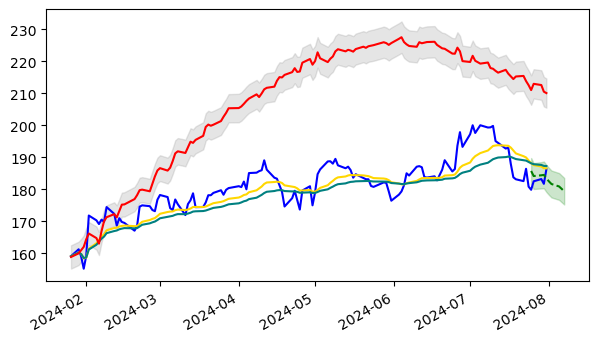

In [7]:
def plot_trend_w_forecast(d, fdf,  fig, ax):
    ax.plot(d.index, d['close'], label = 'Close', color = 'blue')
    ax.plot(d.index, d['close'].ewm(alpha = 1/10).mean(), label = 'Close', color = 'gold')
    ax.plot(d.index, d['close'].ewm(alpha = 1/20).mean(), label = 'Close', color = 'teal')
    ax.plot(d.index, d['prediction'], label = 'Prediction', color = 'red')
    ax.plot(fdf.index, fdf['prediction'], label = 'Earnings Prediction', color = 'green', linestyle = '--')
    ax.fill_between(fdf.index, fdf['lower'], fdf['upper'], color = 'green', alpha = 0.2)
    ax.fill_between(d.index, d['lower'], d['upper'], color = 'grey', alpha = 0.2)
    ax.plot()
    fig.autofmt_xdate()
    
fig, ax = plt.subplots(1, 1, figsize = (7, 4))
plot_trend_w_forecast(pdf, epdf, fig, ax)

In [8]:
epdf.tail(5)

,lower,upper,prediction,close
2024-08-01,178.254860,186.693104,182.473982,NaN
2024-08-02,177.451307,185.855381,181.653344,NaN
2024-08-05,176.699712,185.068704,180.884208,NaN
2024-08-06,175.972522,184.306988,180.139755,NaN
2024-08-07,175.254346,183.554815,179.404580,NaN


Another way we can asses the trend of a stock is by calculating the momentum of the stock price across different time frames. A Daily, Weekly, and Monthly momentum can give us a good idea of the future trend of a stock. When a daily momentum starts to increase, then we should check if the same behavior is happening on the weekly and monthly time frames. If the momentum is increasing on all time frames, then we can say that the stock is in a strong uptrend. Conversly, if the momentum is decreasing on all time frames, then we can say that the stock is in a strong downtrend. 

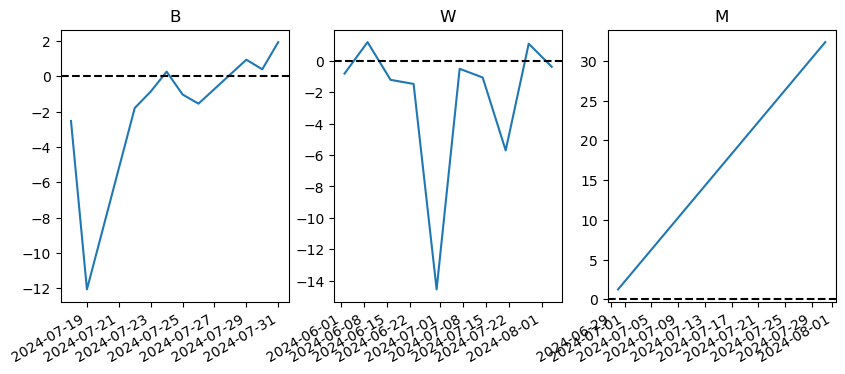

In [48]:
def momentum(prices, n):
    """
    Calculate Momentum
    Args:
        prices (pandas.Series): A Pandas Series with a datetime index
        n (int): Number of days
    """
    lag = prices.shift(n)
    return ((prices - lag ) / lag) 


prices = J.Pricedb.get_close(['tdoc']).tail(130)

prices = prices.rename({list(prices.columns)[-1]: 'close'}, axis=1)
df = prices.pct_change().dropna()
df.index = pd.to_datetime(df.index)
agg_dict = J.Pricedb.get_aggregates(df)
momentum_dict = {key: momentum(value, 5) for key, value in agg_dict.items()}
names = list(momentum_dict.keys())
    
## We want to predict the next periods momentum. 
# If all the momentum is positive, we will buy. If all the momentum is negative, we will sell.
fig, ax = plt.subplots(1, 3, figsize = (10, 4))
ax = ax.flatten()

ax[0].plot(momentum_dict['B'].tail(10))
ax[1].plot(momentum_dict['W'].tail(10))
ax[2].plot(momentum_dict['M'].tail(10))
for x in range(len(ax)):
    ax[x].axhline(0, color = 'black', linestyle = '--')
    ax[x].set_title(names[x])
fig.autofmt_xdate()
plt.show()